In [1]:
import joblib
import numpy as np
import os
import matplotlib.pyplot as plt
import csv


csv       = csv.reader(open('data/ava_kinetics_v1_0/ava_train_v2.2.csv'))
class_sum = {}
for line_ in csv:
    if(len(line_)==8):
        if(int(line_[-2]) in list(class_sum.keys())):
            class_sum[int(line_[-2])] += 1
        else:
            class_sum[int(line_[-2])] = 1
        # class_sum[int(line_[-2])] = class_sum.get(int(line_[-2]), 0) + 1

# joblib.dump(class_sum, 'data/ava_kinetics_v1_0/class_sum.pkl')


reading best file from  logs/1990_4p0/0/results/
[13.222513505213568, 14.240746102772153, 14.692105928387207, 14.794884953498107, 14.971402412081144, 15.169128649638557, 15.376974520508519, 15.237670700601935, 15.85321539183672, 15.682481463038467, 15.910510297956234, 16.11161846678437, 15.800111706773036, 15.538640511565267, 15.778064636326215, 16.06643266775158, 16.16654070152275, 16.234996490231282, 16.25848949544921, 16.524409890637454, 16.347448553910258, 16.699160515541525, 16.57088055699926, 16.678472665515322, 16.637474745999665, 16.584275572320355, 16.577080743978254, 16.572288915644652, 16.64000478739635, 16.64000478739635, 16.64000478739635]
reading best file from  logs/1990_4p3/0/results/
[14.532684044820867, 15.722006066043223, 16.235658952441383, 16.519177886422863, 16.77710924823198, 17.10010480828731, 17.354061401296125, 17.445262821536236, 17.33376247509091, 16.996285797007676, 17.288155153451378, 17.3497962513598, 17.301394982369974, 17.553317083791164, 17.80346178795

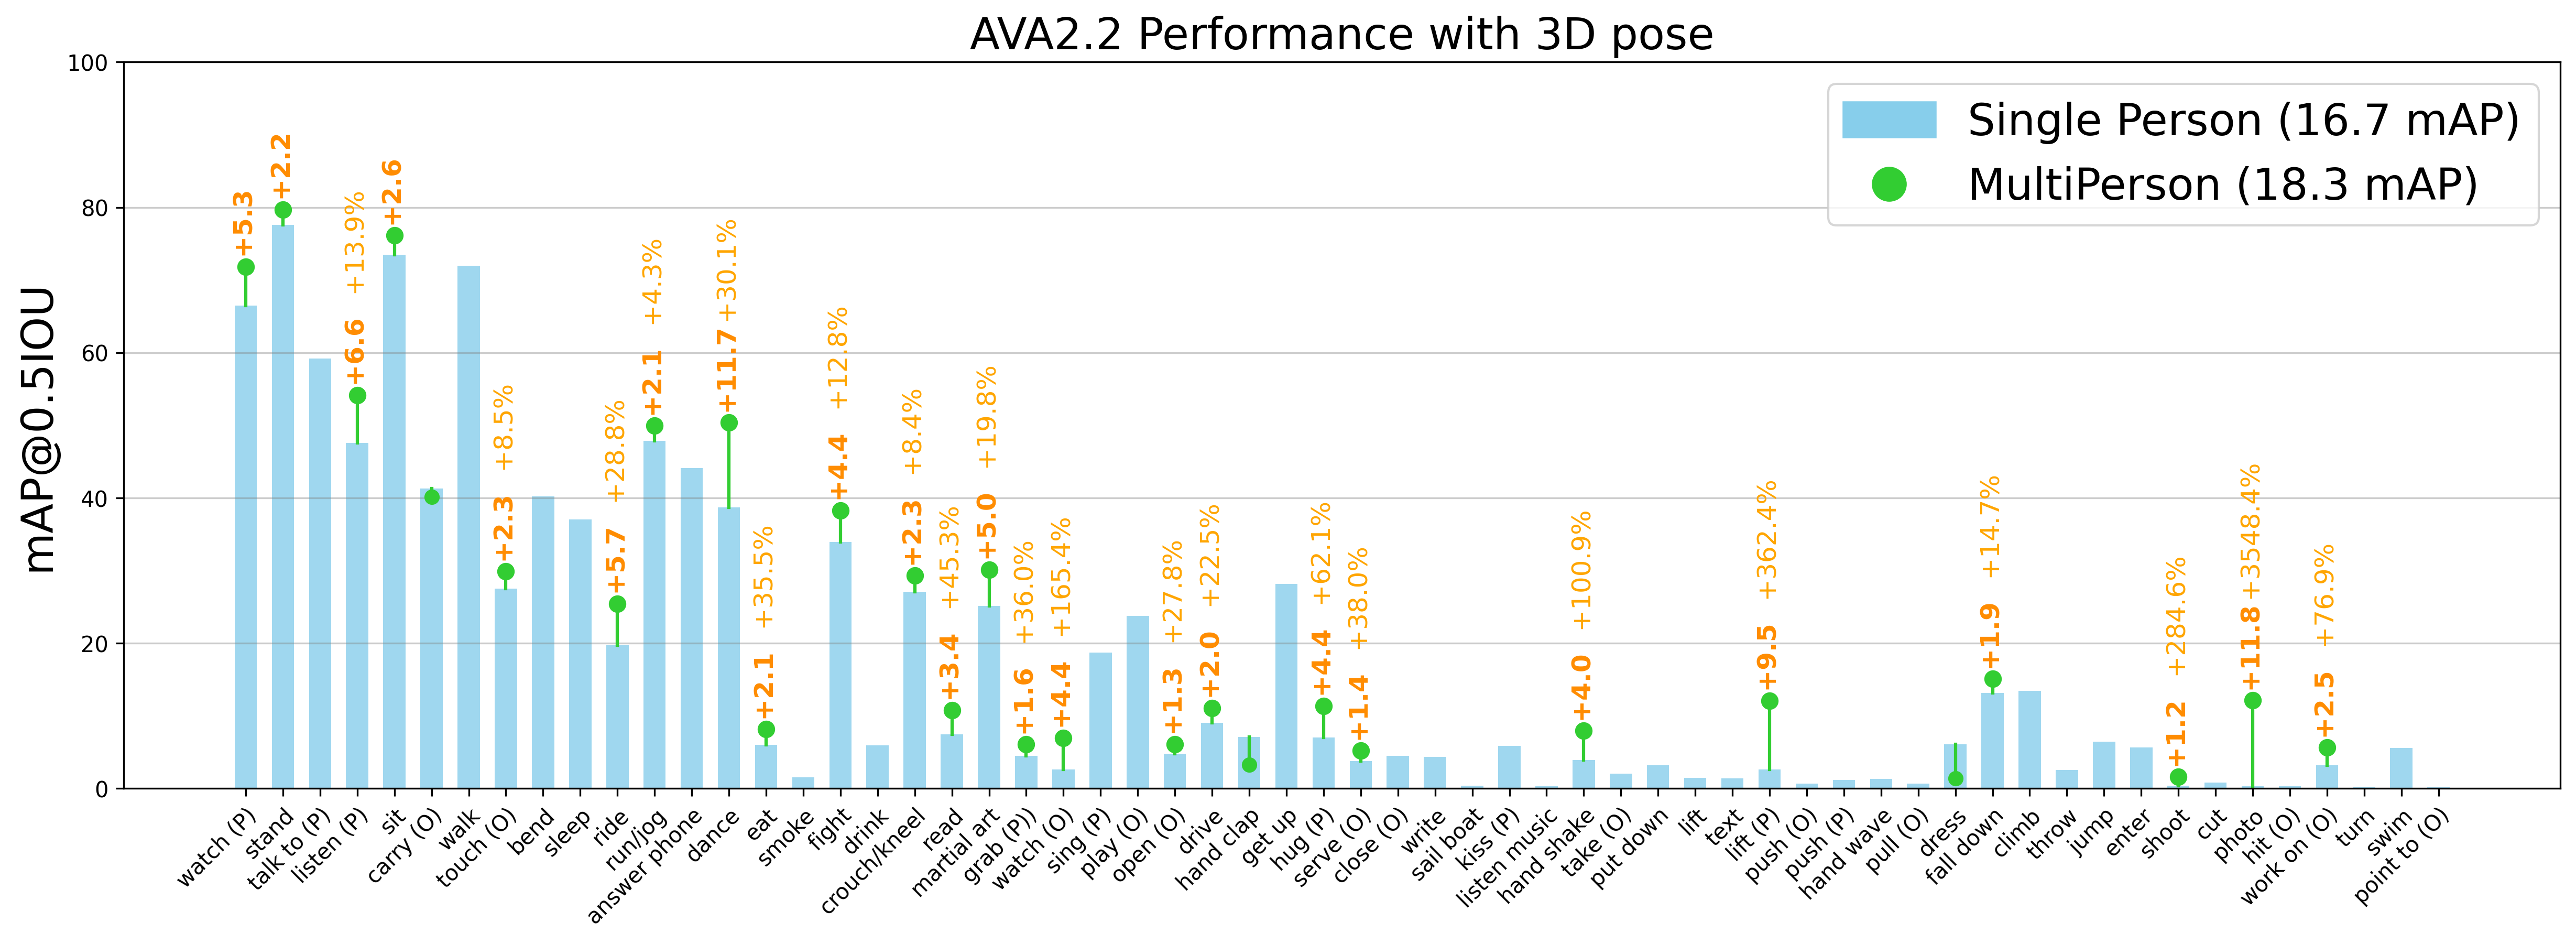

In [13]:

import joblib
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import csv

class_sum = joblib.load('data/ava_kinetics_v1_0/class_sum.pkl')

def read_labelmap(labelmap_file):
  """Reads a labelmap without the dependency on protocol buffers.

  Args:
    labelmap_file: A file object containing a label map protocol buffer.

  Returns:
    labelmap: The label map in the form used by the object_detection_evaluation
      module - a list of {"id": integer, "name": classname } dicts.
    class_ids: A set containing all of the valid class id integers.
  """
  labelmap = {}
  name = ""
  class_id = ""
  class_type = ""
  for line in labelmap_file:
    if line.startswith("  name:"):
      name = line.split('"')[1]
    elif line.startswith("  id:") or line.startswith("  label_id:"):
      class_id = int(line.strip().split(" ")[-1])
    elif line.startswith("  label_type:"):
      class_type = line.strip().split(" ")[-1]
    labelmap[name] = {"id": class_id, "name": name, "type": class_type}
  return labelmap

def read_ava_pkl(pkl_file, refence_file=None, best=False, verbose=True):
    def get_actions(pkl_file):
            
        data          = joblib.load(pkl_file)
        mAP_values    = data[0]
        catagories    = data[1]
        catagories_   = {}
        map_per_class = {}
        for m in catagories: catagories_[m['name']] = m['id']
        for key in mAP_values.keys():
            if("PascalBoxes_PerformanceByCategory/AP@0.5IOU" in key):
                key_                         = key.split("PascalBoxes_PerformanceByCategory/AP@0.5IOU/")[1]
                if(labelmap[key_]['type']!=""): #OBJECT_MANIPULATION, PERSON_INTERACTION,PERSON_MOVEMENT
                  map_per_class[key_]          = mAP_values[key]*100

        actions    = list(map_per_class.keys())
        action_map = list(map_per_class.values())
        counts     = [class_sum[catagories_[i]] for i in actions]
        idx_       = np.argsort(counts)[::-1]
        actions    = np.array(actions)[idx_]
        action_map = np.array(action_map)[idx_]

        return actions, action_map
        
        
    if(best):
        if(verbose): print("reading best file from ", pkl_file)
        files = os.listdir(pkl_file)
        score = []
        results = []
        for file_ in files:
            actions, action_map = get_actions(os.path.join(pkl_file, file_))
            results.append([actions, action_map])
            if(refence_file is None):
                score.append(np.mean(action_map))
            else:
                actions_, action_map_ = refence_file[0], refence_file[1]
                sum_ = 0
                for i in range(len(actions)):
                    if(action_map[i]>action_map_[i]):
                        sum_ += action_map[i]-action_map_[i]
                score.append(sum_)
                
        idx_ = np.argsort(score)[::-1]
        if(verbose): print(score)
        return results[idx_[0]]
    else:  
        if(".pkl" in pkl_file):
            # read the given pkl file
            if(verbose): print("reading ", pkl_file)
            pkl_file = pkl_file
        else:
            # read the last pkl file
            if(verbose): print("reading last file.")
            files = os.listdir(pkl_file)
            filesId = [int(file.split(".")[0]) for file in files]
            ids     = np.argsort(filesId)
            pkl_file = os.path.join(pkl_file, files[-1])
            if(verbose): print(filesId)
            
        return get_actions(pkl_file)
    
labelmap = read_labelmap(open('data/ava_kinetics_v1_0/ava_action_list_v2.2.pbtxt', 'r'))


# actions, action_map = read_ava_pkl("logs/130012/0/results/0.pkl") # MViTv2_40x3   (35.67 mAP)


actions, action_map = read_ava_pkl("logs/1990_4p0/0/results/", best=True)    # SINGLE FRAME INFERENCING
actions_, action_map_ = read_ava_pkl("logs/1990_4p3/0/results/", best=True)    # SINGLE FRAME INFERENCING


# actions, action_map = read_ava_pkl("logs/1990_4p0/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_4p20/0/results/", best=True)    # SINGLE FRAME INFERENCING

# actions, action_map = read_ava_pkl("logs/1990_4p20/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_4p21/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions, action_map = read_ava_pkl("logs/1990_4p30/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_4p31/0/results/", best=True)    # SINGLE FRAME INFERENCING


# actions_, action_map_ = read_ava_pkl("logs/1990_4p20/0/results/", best=True)    # AVAK+VITPOSE (N=1)
# actions_, action_map_ = read_ava_pkl("logs/1990_4p21/0/results/", best=True)    # AVAK+VITPOSE (N=5)
# actions_, action_map_ = read_ava_pkl("logs/1990_4p20x/0/results/", best=True)    # VITPOSE (N=1)

# actions, action_map = read_ava_pkl("logs/1990_4p22/0/results/", best=True)    # HMR (N=1)
# actions_, action_map_ = read_ava_pkl("logs/1990_4p23/0/results/", best=True)    # HMR+VITPOSE(N=1)
# actions_, action_map_ = read_ava_pkl("logs/1990_4p23x/0/results/", best=True)    # HMR+VITPOSE(N=5)


# actions_, action_map_ = read_ava_pkl("logs/2031_5f/0/results/", best=True)    # HMR+VITPOSE(N=5)


actions_sort = ['watch (P)', 'stand',
       'talk to (P)', 'listen (P)',
       'sit', 'carry (O)', 'walk', 'touch (O)',
       'bend', 'sleep',
       'ride', 'run/jog', 'answer phone',
       'dance', 'eat', 'smoke', 'fight', 'drink',
       'crouch/kneel', 'read', 'martial art', 'grab (P))',
       'watch (O)', 'sing (P)',
       'play (O)', 'open (O)',
       'drive', 'hand clap', 'get up',
       'hug (P)', 'serve (O)',
       'close (O)', 'write', 'sail boat',
       'kiss (P)', 'listen music', 'hand shake',
       'take (O)', 'put down', 'lift',
       'text', 'lift (P)',
       'push (O)', 'push (P)', 'hand wave',
       'pull (O)', 'dress', 'fall down',
       'climb', 'throw', 'jump', 'enter', 'shoot',
       'cut', 'photo', 'hit (O)', 'work on (O)',
       'turn', 'swim', 'point to (O)']

actions_x = []
for _, ai in zip(actions,actions_sort):
    actions_x.append(ai)

color_ours = "limegreen"
color_ours_x = "limegreen"
color_base = "skyblue"

plt.figure(figsize=(20,6), dpi=300)
plt.bar(actions_x, action_map,  color=color_base, alpha=0.8, align='center', width=0.6, label='Single Person ' + '(%.1f mAP)'%(np.mean(action_map)))
plt.bar(actions_x, action_map_*0, color=color_ours, alpha=0.8, align='center', width=0.6, label='MultiPerson ' + '(%.1f mAP)'%(np.mean(action_map_)))
plt.xticks(rotation = 45, fontsize=10, rotation_mode='anchor', ha='right')
plt.grid(visible=True, which='major', color='gray', linestyle='-', alpha=0.4)
# plt.grid(visible=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.gca().xaxis.grid(False)

# show legend
gray_patch = mpatches.Circle((0.5, 0.5), 0.25, facecolor=color_base, edgecolor=color_base, linewidth=3, label='Single Person ' + '(%.1f mAP)'%(np.mean(action_map)))
green_dot = mlines.Line2D([], [], color=color_ours, marker='o', linestyle="", markersize=15, label='MultiPerson ' + '(%.1f mAP)'%(np.mean(action_map_)))
plt.legend(fontsize=20, loc='upper right', handles=[gray_patch, green_dot])
# plt.minorticks_on()

plt.ylim(0,100)
plt.title('AVA2.2 Performance with 3D pose', fontsize=20)
plt.ylabel('mAP@0.5IOU', fontsize=20)

sum_pos = 0
sum_neg = 0
th      = 1
avg_classes = []
for i in range(len(actions)):
    if(action_map[i]<action_map_[i]):
        if(action_map_[i]-action_map[i]>th):
            plt.text(i, action_map_[i], ' +%.1f'%(action_map_[i]-action_map[i]), color='darkorange', fontweight='bold', fontsize=12, rotation = 90, ha='center', va='bottom')
            if(action_map_[i]<60):
              plt.text(i, action_map_[i], '            +%.1f%%'%((action_map_[i]-action_map[i])/action_map[i]*100), color='orange', fontsize=12, rotation = 90, ha='center', va='bottom')
            plt.plot(i, action_map_[i], 'o', color=color_ours, alpha=1, markersize=7)
            plt.plot([i, i], [action_map_[i], action_map[i]], color=color_ours, alpha=1)
            sum_pos += action_map_[i]-action_map[i]
            avg_classes.append(labelmap[actions[i]]['id'])
    else:   
        if(action_map[i]-action_map_[i]>th):
            # plt.text(i, action_map_[i], ' -%.2f'%(action_map[i]-action_map_[i]), color='orange', fontweight='bold', fontsize=15, rotation = 90, ha='center', va='bottom')
            plt.plot(i, action_map_[i], 'o', color=color_ours_x, alpha=1)
            plt.plot([i, i], [action_map_[i], action_map[i]], color=color_ours_x, alpha=1)
            sum_neg += action_map[i]-action_map_[i]

print(sum_pos, sum_pos/60)
print(sum_neg, sum_neg/60)
plt.show()

In [1]:
labelmap = read_labelmap(open('data/ava_kinetics_v1_0/ava_action_list_v2.2_for_activitynet.pbtxt', 'r'))

valid_classes = []
for k in labelmap.keys():
    if(k!=""):
        # print(labelmap[k]['id'])
        valid_classes.append(labelmap[k]['id'])
np.save('data/ava_valid_classes.npy', valid_classes)

class_mappping = {}
for i, k in enumerate(valid_classes):
    class_mappping[i+1] = k
class_mappping[0] = 0
joblib.dump(class_mappping, 'data/ava_class_mappping.pkl')

NameError: name 'read_labelmap' is not defined

reading  logs/130010/0/results/0.pkl
reading best file from  logs/2007_24f/0/results/
[41.486326620546286, 41.54520272993538, 41.56247079241657, 41.51257834380995, 41.391836153711004, 41.653888113469115, 41.450323003316974, 41.341680816662006, 41.52144540699253, 41.45737001440083, 41.388085302627616, 41.40783643330568, 41.38355774291996, 41.404021500095425, 41.30516268271597, 41.41799795073119, 41.34533882404883, 41.358469046394625, 41.417814475711175, 41.35954359982923, 41.38294731214762, 41.29249727349195, 41.31308523558933, 41.309045079178, 41.28650092771212]
reading best file from  logs/2007_7t/0/results/
[41.192268834814016, 41.239625679999946, 41.39217354728981, 41.344170613791874, 41.31446235353223, 41.56164690128153, 41.39131184193353, 41.4112853965844, 41.44276986156506, 41.496718259851654, 41.36101218700579, 41.44998303383445, 41.40877584715638, 41.37527207823401, 41.36340270288746, 41.34985176930591, 41.41610724832468, 41.452731016063126, 41.40041996550935, 41.43451982998186

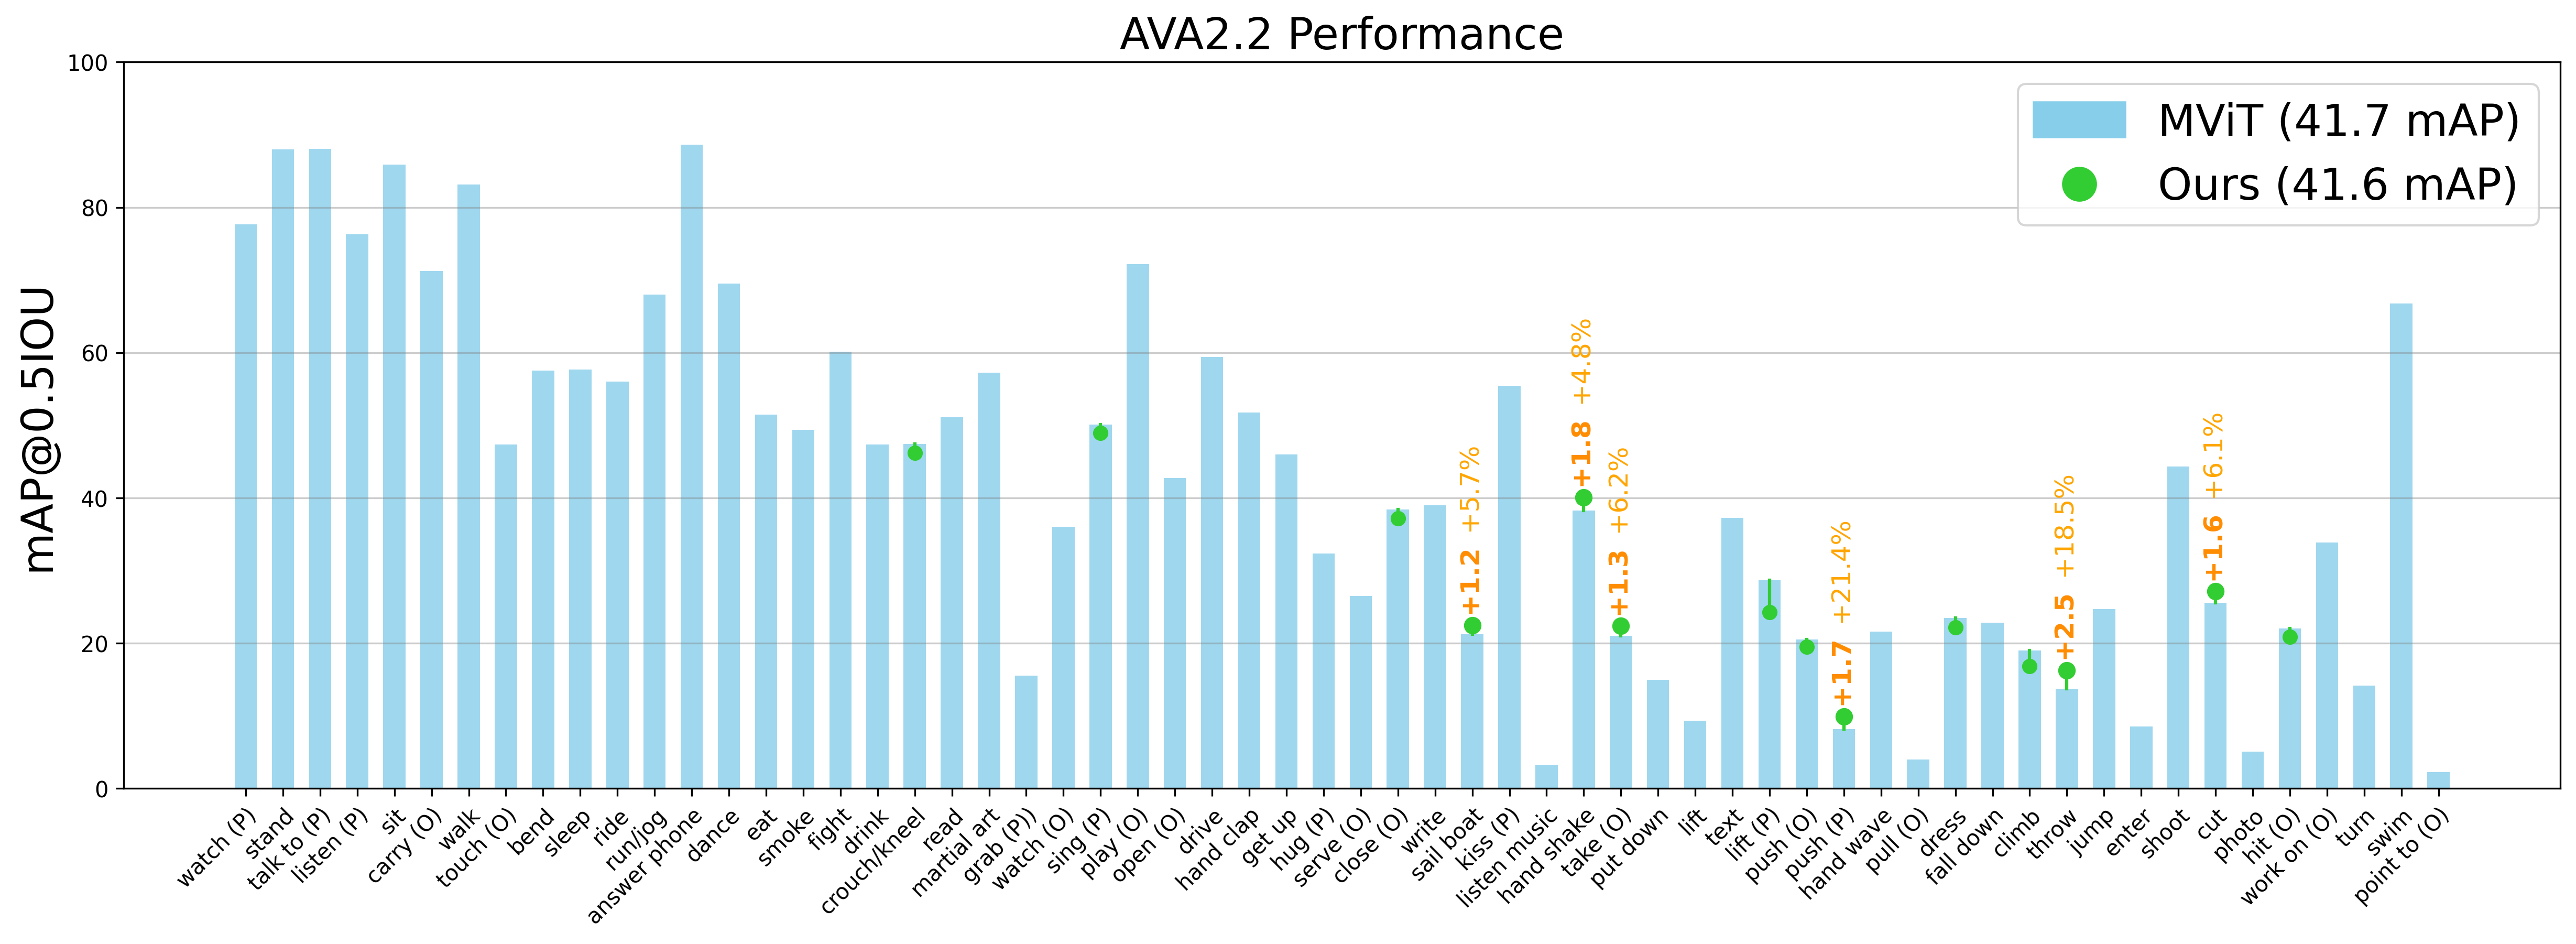

In [23]:

import joblib
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import csv

class_sum = joblib.load('data/ava_kinetics_v1_0/class_sum.pkl')

def read_labelmap(labelmap_file):
  """Reads a labelmap without the dependency on protocol buffers.

  Args:
    labelmap_file: A file object containing a label map protocol buffer.

  Returns:
    labelmap: The label map in the form used by the object_detection_evaluation
      module - a list of {"id": integer, "name": classname } dicts.
    class_ids: A set containing all of the valid class id integers.
  """
  labelmap = {}
  name = ""
  class_id = ""
  class_type = ""
  for line in labelmap_file:
    if line.startswith("  name:"):
      name = line.split('"')[1]
    elif line.startswith("  id:") or line.startswith("  label_id:"):
      class_id = int(line.strip().split(" ")[-1])
    elif line.startswith("  label_type:"):
      class_type = line.strip().split(" ")[-1]
    labelmap[name] = {"id": class_id, "name": name, "type": class_type}
  return labelmap

def read_ava_pkl(pkl_file, refence_file=None, best=False, verbose=True):
    def get_actions(pkl_file):
            
        data          = joblib.load(pkl_file)
        mAP_values    = data[0]
        catagories    = data[1]
        catagories_   = {}
        map_per_class = {}
        for m in catagories: catagories_[m['name']] = m['id']
        for key in mAP_values.keys():
            if("PascalBoxes_PerformanceByCategory/AP@0.5IOU" in key):
                key_                         = key.split("PascalBoxes_PerformanceByCategory/AP@0.5IOU/")[1]
                if(labelmap[key_]['type']!=""): #OBJECT_MANIPULATION, PERSON_INTERACTION,PERSON_MOVEMENT
                  map_per_class[key_]          = mAP_values[key]*100

        actions    = list(map_per_class.keys())
        action_map = list(map_per_class.values())
        counts     = [class_sum[catagories_[i]] for i in actions]
        idx_       = np.argsort(counts)[::-1]
        actions    = np.array(actions)[idx_]
        action_map = np.array(action_map)[idx_]

        return actions, action_map
        
        
    if(best):
        if(verbose): print("reading best file from ", pkl_file)
        files = os.listdir(pkl_file)
        score = []
        results = []
        for file_ in files:
            actions, action_map = get_actions(os.path.join(pkl_file, file_))
            results.append([actions, action_map])
            if(refence_file is None):
                score.append(np.mean(action_map))
            else:
                actions_, action_map_ = refence_file[0], refence_file[1]
                sum_ = 0
                for i in range(len(actions)):
                    if(action_map[i]>action_map_[i]):
                        sum_ += action_map[i]-action_map_[i]
                score.append(sum_)
                
        idx_ = np.argsort(score)[::-1]
        if(verbose): print(score)
        return results[idx_[0]]
    else:  
        if(".pkl" in pkl_file):
            # read the given pkl file
            if(verbose): print("reading ", pkl_file)
            pkl_file = pkl_file
        else:
            # read the last pkl file
            if(verbose): print("reading last file.")
            files = os.listdir(pkl_file)
            filesId = [int(file.split(".")[0]) for file in files]
            ids     = np.argsort(filesId)
            pkl_file = os.path.join(pkl_file, files[-1])
            if(verbose): print(filesId)
            
        return get_actions(pkl_file)
    
labelmap = read_labelmap(open('data/ava_kinetics_v1_0/ava_action_list_v2.2.pbtxt', 'r'))

### SF/MViT models ###
# actions, action_map = read_ava_pkl("logs/13003/results/0.pkl") # CLIP          ( 8.40 mAP)
# actions, action_map = read_ava_pkl("logs/13001/results/0.pkl") # SF_R50_8x8    (22.44 mAP)
# actions_, action_map_ = read_ava_pkl("logs/13002/results/0.pkl") # SF_R101_64x2  (24.02 mAP)
# actions, action_map = read_ava_pkl("logs/13004/results/0.pkl") # MViTv2_40x3   (35.56 mAP)
# actions, action_map = read_ava_pkl("logs/13005/results/0.pkl") # MViTv2_40x3   (35.67 mAP)
# actions, action_map = read_ava_pkl("logs/13006/results/0.pkl") # MViTv2_40x3   (35.67 mAP)
# actions, action_map = read_ava_pkl("logs/13007/results/0.pkl") # MViTv2_40x3   (35.67 mAP)
# actions, action_map = read_ava_pkl("logs/13008/0/results/0.pkl") # MViTv2_40x3   (35.67 mAP)
actions, action_map = read_ava_pkl("logs/130010/0/results/0.pkl") # MViTv2_40x3   (35.67 mAP)
# actions, action_map = read_ava_pkl("logs/130012/0/results/0.pkl") # MViTv2_40x3   (35.67 mAP)
# actions, action_map = read_ava_pkl("logs/13007/results/0.pkl") # MViTv2_40x3   (35.67 mAP)

# actions_, action_map_ = read_ava_pkl("logs/130011/0/results/0.pkl") # MViTv2_40x3   (35.67 mAP)


# actions, action_map = read_ava_pkl("data/1047_3_test_0.7_1.0.pkl")   
# actions, action_map = read_ava_pkl("logs/1400/results/", best=True)   
# actions_, action_map_ = read_ava_pkl("logs/1813b/results/", best=True)   
# actions_, action_map_ = read_ava_pkl("logs/1813b_test/results/", best=True)   

# actions_, action_map_ = read_ava_pkl("logs/1946/results/", best=True)   
# actions_, action_map_ = read_ava_pkl("logs/1946/results/", best=True, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/1946_test/results/", best=True, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/1949/results/", best=False, refence_file=[actions, action_map])   


# actions_, action_map_ = read_ava_pkl("logs/1961a/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/1962c/results/", best=True, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/1962b/results/", best=True, refence_file=[actions, action_map])   


# actions_, action_map_ = read_ava_pkl("logs/1970b/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/1970d/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/1971/2/results/", best=True)  
# actions, action_map = read_ava_pkl("logs/1970d/0/results/", best=True, refence_file=[actions, action_map])   

# actions_, action_map_ = read_ava_pkl("logs/19602/0/results/", best=True, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19603/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19605/0/results/", best=True, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19606/0/results/", best=False, refence_file=[actions, action_map])   

# actions_, action_map_ = read_ava_pkl("logs/19607/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19608/0/results/", best=False, refence_file=[actions, action_map])   

# actions_, action_map_ = read_ava_pkl("logs/1973p1/0/results/", best=True, refence_file=[actions, action_map])   

# actions_, action_map_ = read_ava_pkl("logs/19610a/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19610b/12/results/", best=False, refence_file=[actions, action_map])   


# actions_, action_map_ = read_ava_pkl("logs/19611a/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19612a/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19611b/0/results/", best=True, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19611c/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19611d/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19611e/0/results/", best=False, refence_file=[actions, action_map])   


# actions, action_map = read_ava_pkl("logs/19613c/4/results/0.5.pkl", best=False, refence_file=[actions, action_map])   

# actions_, action_map_ = read_ava_pkl("logs/19612a/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19612b/0/results/", best=False, refence_file=[actions, action_map])   
# actions_, action_map_ = read_ava_pkl("logs/19612d/0/results/", best=False)   
# actions, action_map = read_ava_pkl("logs/19612e/0/results/0.pkl", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612e/0/results/", best=False)  
# actions, action_map = read_ava_pkl("logs/1980/0/results/", best=True)  
# actions_, action_map_ = read_ava_pkl("logs/19612g/6/results/", best=True)  
# actions_, action_map_ = read_ava_pkl("logs/19613g/8/results/", best=True)  

# actions_, action_map_ = read_ava_pkl("logs/19612h/0/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612i/0/results/", best=True)  
# actions_, action_map_ = read_ava_pkl("logs/19612h2/0/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612h3/0/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612h4/0/results/", best=False)  


# actions_, action_map_ = read_ava_pkl("logs/1970h2_finetune2/0/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19611o_finetune1/0/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612l/0/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612m/7/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612o/0/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612n/0/results/", best=False)  
# actions_, action_map_ = read_ava_pkl("logs/19612n5/0/results/", best=False)  





# actions_, action_map_ = read_ava_pkl("logs/19612g6_test/0/results/", best=True)  
# actions_, action_map_ = read_ava_pkl("logs/1981/0/results/", best=True)  
# actions_, action_map_ = read_ava_pkl("logs/1982/0/results/", best=True)  
# actions_, action_map_ = read_ava_pkl("logs/1982_test3/0/results/", best=True)  
# actions_, action_map_ = read_ava_pkl("logs/1982_test5/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions, action_map = read_ava_pkl("logs/1982_test5/0/results/", best=True)  # MULTI FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1982a/0/results/", best=True)  

# actions, action_map = read_ava_pkl("logs/1990_1a/0/results/0.pkl", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_1a/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_1b/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_1c/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_1d/0/results/", best=False)    # SINGLE FRAME INFERENCING


# actions_, action_map_ = read_ava_pkl("logs/1990/8/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_3a/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions, action_map = read_ava_pkl("logs/1990_3a/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_3b/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_3e/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_3c/0/results/", best=True)    # SINGLE FRAME INFERENCING



# actions_, action_map_ = read_ava_pkl("logs/1990_4a/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions, action_map = read_ava_pkl("logs/1990_3e/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_3e_test3/0/results/", best=False)    # SINGLE FRAME INFERENCING


# actions_, action_map_ = read_ava_pkl("logs/1990_4f/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_5f/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6f/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_7f/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_8f/0/results/", best=False)    # SINGLE FRAME INFERENCING

# actions, action_map = read_ava_pkl("logs/1990_8t/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6t/0/results/", best=True)    # SINGLE FRAME INFERENCING

# actions, action_map = read_ava_pkl("logs/1990_4p0/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_4p1/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_4p3/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_4p3_t1/0/results/", best=True)    # SINGLE FRAME INFERENCING

# actions, action_map = read_ava_pkl("logs/1990_6f2/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6f3/0/results/", best=True)    # SINGLE FRAME INFERENCING

# actions, action_map = read_ava_pkl("logs/1990_6f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions, action_map = read_ava_pkl("logs/1990_6t/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6f4/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1999/29/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6f6/0/results/", best=True)    # SINGLE FRAME INFERENCING

# actions_, action_map_ = read_ava_pkl("logs/1999/22/results/", best=True)    # SINGLE FRAME INFERENCING

# actions, action_map = read_ava_pkl("logs/1990_6f/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions, action_map = read_ava_pkl("logs/1990_5f/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_5f_test2/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_5f_test3/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1999/6/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6f/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1999_6f2/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6f6/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6f7/0/results/", best=True)    # SINGLE FRAME INFERENCING

# actions_, action_map_ = read_ava_pkl("logs/1999_6f5/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_5f8/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1991_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1992_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions, action_map = read_ava_pkl("logs/1993_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1998_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1999_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING

# actions_, action_map_ = read_ava_pkl("logs/1997_5f_test_x6$/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1999_5f_test2/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/2007_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/2007_5f_test_y2$/0/results/", best=True)    # SINGLE FRAME INFERENCING



# actions, action_map = read_ava_pkl("logs/2007_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions, action_map = read_ava_pkl("logs/2020_7f/0/results/0.pkl", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/2020_7f/0/results/", best=False)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("_TMP/logs5/1990_6f6/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6f6/0/results/", best=True)    # SINGLE FRAME INFERENCING


# actions_, action_map_ = read_ava_pkl("logs/2033_5f/0/results/", best=0)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/2034_5f/0/results/", best=0)    # SINGLE FRAME INFERENCING

# actions, action_map = read_ava_pkl("logs/2007_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/2007_23f/0/results/", best=0)    # SINGLE FRAME INFERENCING

# actions_, action_map_ = read_ava_pkl("logs/1990_8f/0/results/", best=1)    # MVIT+Tracking only


# actions_, action_map_ = read_ava_pkl("logs/1990_4t2/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/1990_6t/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/2007_5f/0/results/", best=True)    # SINGLE FRAME INFERENCING
# actions_, action_map_ = read_ava_pkl("logs/2007_24f/0/results/", best=1)    # SINGLE FRAME INFERENCING


actions, action_map = read_ava_pkl("logs/2007_24f/0/results/", best=1)    # SINGLE FRAME INFERENCING
actions_, action_map_ = read_ava_pkl("logs/2007_7t/0/results/", best=1)    # SINGLE FRAME INFERENCING


actions_sort = ['watch (P)', 'stand',
       'talk to (P)', 'listen (P)',
       'sit', 'carry (O)', 'walk', 'touch (O)',
       'bend', 'sleep',
       'ride', 'run/jog', 'answer phone',
       'dance', 'eat', 'smoke', 'fight', 'drink',
       'crouch/kneel', 'read', 'martial art', 'grab (P)',
       'watch (O)', 'sing (P)',
       'play (O)', 'open (O)',
       'drive', 'hand clap', 'get up',
       'hug (P)', 'serve (O)',
       'close (O)', 'write', 'sail boat',
       'kiss (P)', 'listen music', 'hand shake',
       'take (O)', 'put down', 'lift',
       'text', 'lift (P)',
       'push (O)', 'push (P)', 'hand wave',
       'pull (O)', 'dress', 'fall down',
       'climb', 'throw', 'jump', 'enter', 'shoot',
       'cut', 'photo', 'hit (O)', 'work on (O)',
       'turn', 'swim', 'point to (O)']

actions_x = []
for _, ai in zip(actions,actions_sort):
    actions_x.append(ai)

color_ours = "limegreen"
color_ours_x = "limegreen"
color_base = "skyblue"

plt.figure(figsize=(20,6), dpi=300)
plt.bar(actions_x, action_map,  color=color_base, alpha=0.8, align='center', width=0.6, label='Single Person ' + '(%.1f mAP)'%(np.mean(action_map)))
plt.bar(actions_x, action_map_*0, color=color_ours, alpha=0.8, align='center', width=0.6, label='MultiPerson ' + '(%.1f mAP)'%(np.mean(action_map_)))
plt.xticks(rotation = 45, fontsize=10, rotation_mode='anchor', ha='right')
plt.grid(visible=True, which='major', color='gray', linestyle='-', alpha=0.4)
# plt.grid(visible=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.gca().xaxis.grid(False)

# show legend
gray_patch = mpatches.Circle((0.5, 0.5), 0.25, facecolor=color_base, edgecolor=color_base, linewidth=3, label='MViT ' + '(%.1f mAP)'%(np.mean(action_map)))
green_dot = mlines.Line2D([], [], color=color_ours, marker='o', linestyle="", markersize=15, label='Ours ' + '(%.1f mAP)'%(np.mean(action_map_)))
plt.legend(fontsize=20, loc='upper right', handles=[gray_patch, green_dot])
# plt.minorticks_on()

plt.ylim(0,100)
plt.title('AVA2.2 Performance', fontsize=20)
plt.ylabel('mAP@0.5IOU', fontsize=20)

sum_pos = 0
sum_neg = 0
th      = 1
avg_classes = []
for i in range(len(actions)):
    if(action_map[i]<action_map_[i]):
        if(action_map_[i]-action_map[i]>th):
            plt.text(i, action_map_[i], ' +%.1f'%(action_map_[i]-action_map[i]), color='darkorange', fontweight='bold', fontsize=12, rotation = 90, ha='center', va='bottom')
            if(action_map_[i]<600):
              plt.text(i, action_map_[i], '           +%.1f%%'%((action_map_[i]-action_map[i])/action_map[i]*100), color='orange', fontsize=12, rotation = 90, ha='center', va='bottom')
            plt.plot(i, action_map_[i], 'o', color=color_ours, alpha=1, markersize=7)
            plt.plot([i, i], [action_map_[i], action_map[i]], color=color_ours, alpha=1)
            sum_pos += action_map_[i]-action_map[i]
            avg_classes.append(labelmap[actions[i]]['id'])
    else:   
        if(action_map[i]-action_map_[i]>th):
            # plt.text(i, action_map_[i], ' -%.2f'%(action_map[i]-action_map_[i]), color='orange', fontweight='bold', fontsize=15, rotation = 90, ha='center', va='bottom')
            plt.plot(i, action_map_[i], 'o', color=color_ours_x, alpha=1)
            plt.plot([i, i], [action_map_[i], action_map[i]], color=color_ours_x, alpha=1)
            sum_neg += action_map[i]-action_map_[i]

print(sum_pos, sum_pos/60)
print(sum_neg, sum_neg/60)
plt.show()

In [19]:
import torch
torch.rand(1).item()

0.8843026161193848

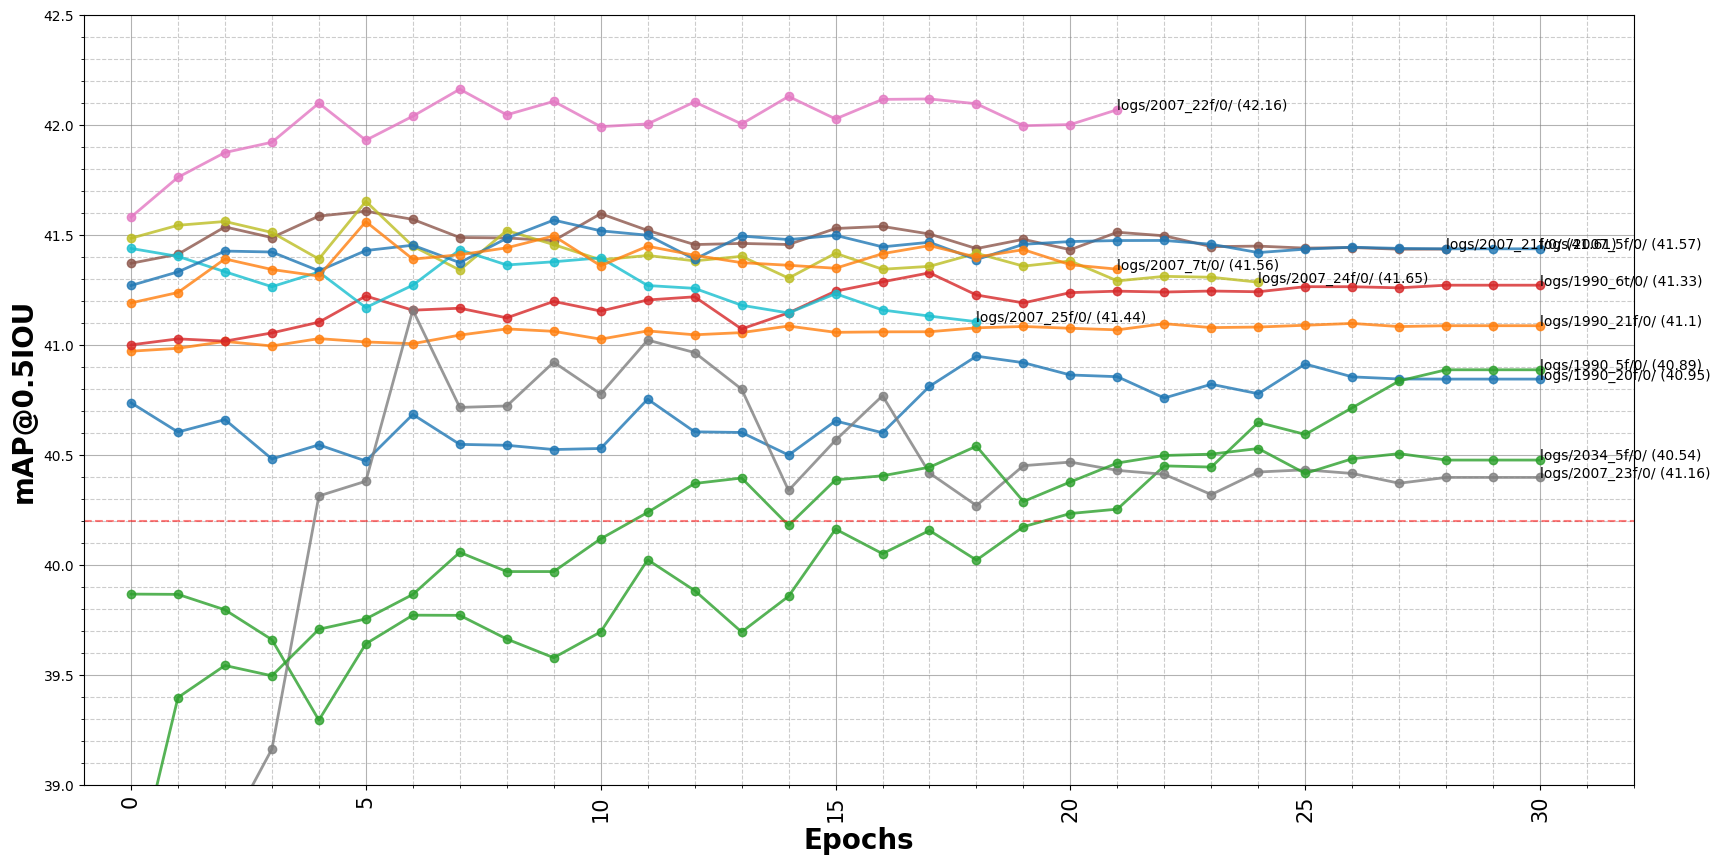

In [3]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt 

def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

# plt.style.use("dark_background")
plt.figure(figsize=(20,10))

runs = [i for i in np.sort(os.listdir("logs")) if "." not in i]
runs_all = runs.copy()
for r_ in runs:
    r2 = [i for i in os.listdir("logs/"+r_)]
    for r2_ in r2:
        runs_all.append("logs/" + r_ + "/" + r2_ + "/")
key_ = "mAP : "

# runs_all.append("_TMP/logs5/1990_6f4/0/")

plt.xlim(-1,32)
plt.ylim(39,42.5)
for run in runs_all:
    if(
        (
            ("1990_5f" in run) or
            ("2007_5f" in run) or
            
            
            # ("2033_5f" in run) or
            ("2034_5f" in run) or
            ("1990_20f" in run) or
            ("1990_21f" in run) or
            ("2007_21f" in run) or
            ("2007_22f" in run) or
            ("2007_23f" in run) or
            ("2007_24f" in run) or
            ("2007_25f" in run) or
            
            
            ("2007_7t" in run) or
            
            ("6t" in run) or
            ("testx" in run)
        )
        and "test" not in run):
        
        path  = run + "/results/"
        try:
            files = list([i for i in os.listdir(path) if ".pkl" in i])
            files_id = list([int(i.split(".")[0]) for i in os.listdir(path) if ".pkl" in i])
            loc_ = np.argsort(files_id)
            files = np.array(files)[loc_]
            results_x = []
            results_y = []
            for file_ in files:
                try:
                    actions_, action_map_ = read_ava_pkl(path + file_, verbose=False)
                    results_x.append(int(file_.split(".")[0]))
                    results_y.append(np.mean(action_map_))
                except:
                    pass
            
            # if(max(results_y)<40.8 and results_x[-1]==30): continue
            
            plt.plot(results_x, results_y, label=run, alpha=0.8, linewidth=2, marker='o')
            # print label 
            if(max(results_y)>plt.gca().get_ylim()[0] and max(results_y)<plt.gca().get_ylim()[1] and results_x[-1]<plt.gca().get_xlim()[1]):
                # plt.text(results_x[np.argmax(results_y)], max(results_y), run + " (" + str(round(max(results_y), 2)) + ")", fontsize=10)
                plt.text(results_x[-1], results_y[-1], run + " (" + str(round(max(results_y), 2)) + ")", fontsize=10)
                pass
        except Exception as e:
            pass
    
# draw horizontal line
# plt.axhline(y=37.89, color='r', linestyle='--', alpha=0.5)
# plt.axhline(y=39.50, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=40.20, color='r', linestyle='--', alpha=0.5)


plt.xticks(rotation = 90, fontsize=15)
plt.grid(visible=True, which='major', color='gray', linestyle='-', alpha=0.6)
plt.grid(visible=True, which='minor', color='gray', linestyle='--', alpha=0.4)
# plt.legend(fontsize=10, loc='lower right', ncol=8)
plt.minorticks_on()
plt.ylabel('mAP@0.5IOU', fontweight='bold', fontsize=20)
plt.xlabel('Epochs', fontweight='bold', fontsize=20)
# 51635
# 92629
# 52391
# 97148
plt.show()

In [ ]:
np.save("data/max_pool_clases.npy", avg_classes)

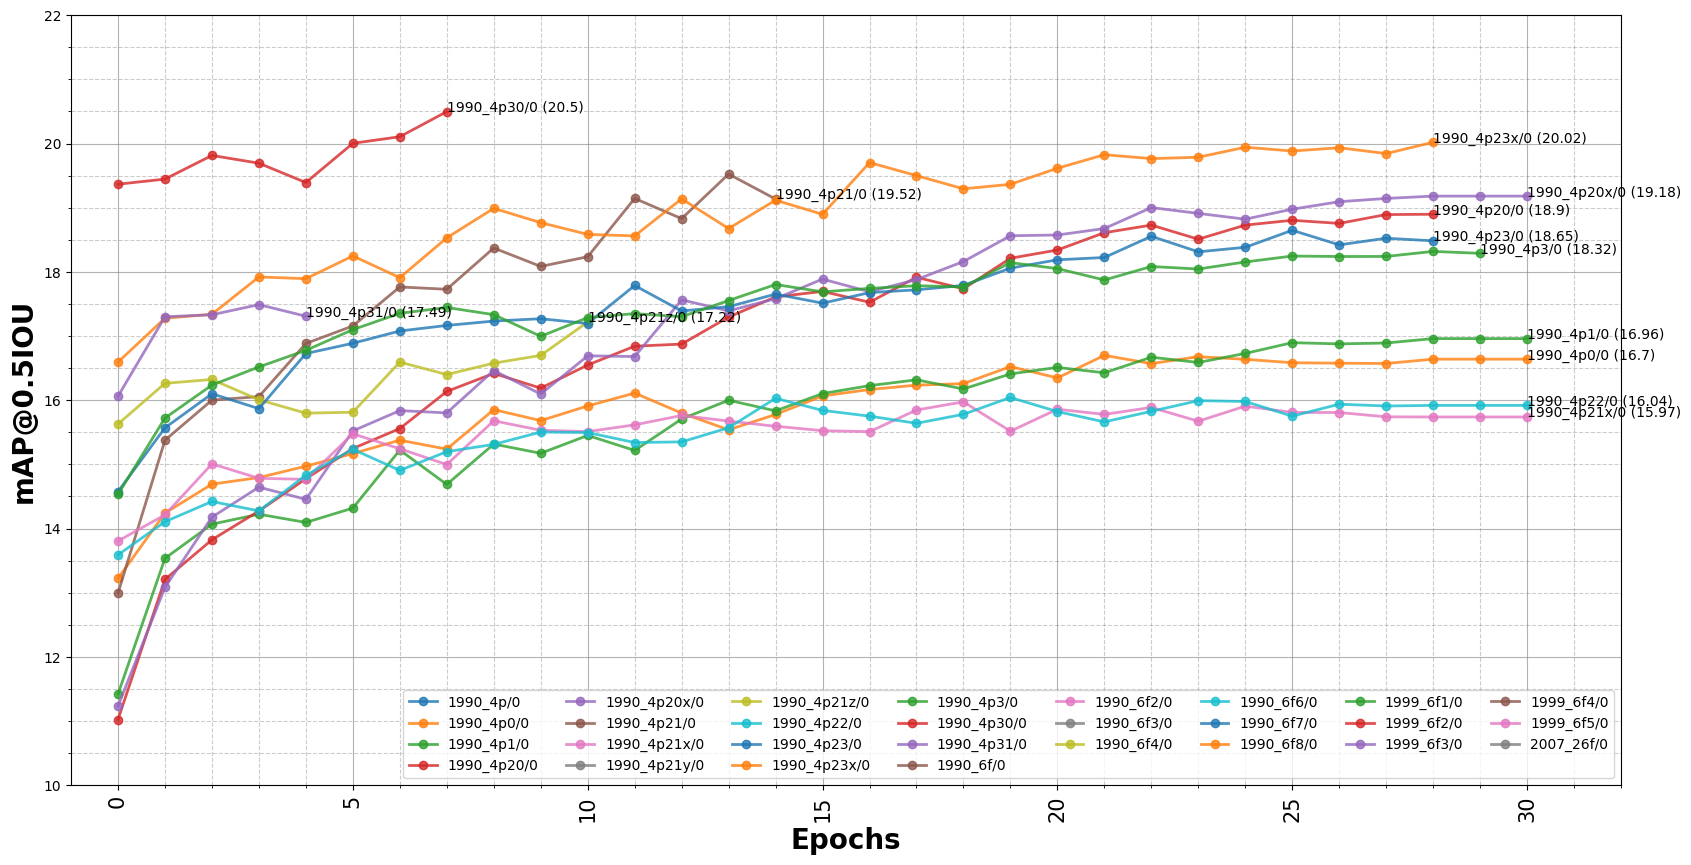

In [3]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt 

def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

# plt.style.use("dark_background")
plt.figure(figsize=(20,10))

runs = [i for i in np.sort(os.listdir("logs")) if "." not in i]
runs_all = runs.copy()
for r_ in runs:
    r2 = [i for i in os.listdir("logs/"+r_)]
    for r2_ in r2:
        runs_all.append(r_ + "/" + r2_)
key_ = "mAP : "

skip_runs = [] #["1972e/0"]

plt.xlim(-1,32)
plt.ylim(10,22.0)
# plt.ylim(39,42.0)
# plt.ylim(40.8,42.0)
for run in runs_all:
    # if((run.split("/")[0][:6]=="19610e")):
    #  or run.split("/")[0][:5]=="19613f" or run.split("/")[0][:5]=="1970h") and (run.split("/")[0][:6]!="19612c" and run.split("/")[0][:7]!="19612h2")
    if(
        (
            ("6f" in run) or
            ("p" in run) or
            ("test" in run)
        )
        and "test" not in run):
        
        path  = "logs/" + run + "/results/"
        try:
            files = list([i for i in os.listdir(path) if ".pkl" in i])
            files_id = list([int(i.split(".")[0]) for i in os.listdir(path) if ".pkl" in i])
            loc_ = np.argsort(files_id)
            files = np.array(files)[loc_]
            results_x = []
            results_y = []
            for file_ in files:
                try:
                    actions_, action_map_ = read_ava_pkl(path + file_, verbose=False)
                    results_x.append(int(file_.split(".")[0]))
                    results_y.append(np.mean(action_map_))
                except:
                    pass
            plt.plot(results_x, results_y, label=run, alpha=0.8, linewidth=2, marker='o')
            # print label 
            if(max(results_y)>plt.gca().get_ylim()[0] and max(results_y)<plt.gca().get_ylim()[1] and results_x[-1]<plt.gca().get_xlim()[1]):
                # plt.text(results_x[np.argmax(results_y)], max(results_y), run + " (" + str(round(max(results_y), 2)) + ")", fontsize=10)
                plt.text(results_x[-1], results_y[-1], run + " (" + str(round(max(results_y), 2)) + ")", fontsize=10)
            
        except Exception as e:
            pass
    
# draw horizontal line
# plt.axhline(y=37.89, color='r', linestyle='--', alpha=0.5)
# plt.axhline(y=39.50, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=40.20, color='r', linestyle='--', alpha=0.5)


plt.xticks(rotation = 90, fontsize=15)
plt.grid(visible=True, which='major', color='gray', linestyle='-', alpha=0.6)
plt.grid(visible=True, which='minor', color='gray', linestyle='--', alpha=0.4)
plt.legend(fontsize=10, loc='lower right', ncol=8)
plt.minorticks_on()
plt.ylabel('mAP@0.5IOU', fontweight='bold', fontsize=20)
plt.xlabel('Epochs', fontweight='bold', fontsize=20)
# 51635
# 92629
# 52391
# 97148
plt.show()

In [5]:
import mvp

model = mvp.load("vitb-mae-egosoup")
model.freeze()

/private/home/jathushan/.conda/envs/HUMAN_BERT_2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  [============================================================] 100.0% of 327.3MB file  
Loaded encoder from: /tmp/mvp-download-cache/vitb-mae-egosoup.pth


In [ ]:
import joblib

# a1 = joblib.load("/private/home/jathushan/3D/BERT_person_hydra/_TMP/logs3/avaK-train_riding_elephant_._9QFbo-DKo14_._00120_4_116.pkl")
a1 = joblib.load("/checkpoint/jathushan/TENET/out/Videos_v4.500_ava_train/results/ava-train_piYxcrMxVPw_023790.pkl")

In [ ]:
a1['piYxcrMxVPw_023790.jpg']

In [3]:
from tqdm import tqdm
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from pytorchvideo.data.ava import AvaLabeledVideoFramePaths

AVA_VALID_FRAMES = range(902, 1799)
ava_valid_classes = joblib.load("data/ava_class_mappping.pkl")
label_map, allowed_class_ids = AvaLabeledVideoFramePaths.read_label_map('data/ava_action_list.pbtxt')

# a1 = np.load("/private/home/jathushan/3D/BERT_person_hydra/logs/1990_3b_test3/0/svm_vectors.npy", allow_pickle=True)
# X_train = []
# Y_train = []
# for i in tqdm(range(len(a1))):
#     labels = np.where(a1[i][1]==1)[0]
#     for lab in labels:
#         X_train.append(a1[i][0])
#         Y_train.append(int(lab))

# X_train = np.array(X_train)
# Y_train = np.array(Y_train)


f = open("/private/home/jathushan/3D/BERT_person_hydra/logs/1990_3b_test4/0/ava.csv", 'w')
writer = csv.writer(f)
counter = 0
        
b1 = np.load("/private/home/jathushan/3D/BERT_person_hydra/logs/1990_3b_test4/0/svm_pred_vectors.npy", allow_pickle=True)
X_pred = []
X_name = []
for i in tqdm(range(len(b1))):
    data = b1[i]
    slowfast_file = b1[i][0]

    # make predctions with SVM classifier
    svm_predictions = np.zeros((60,))
    
    video_id  = slowfast_file.split("ava-val_")[1][:11]
    key_frame = slowfast_file.split("ava-val_")[1][12:18]
    frame_id  = "%04d"%(int(key_frame)//30 + 900,)
    if(int(key_frame)//30+900 not in AVA_VALID_FRAMES): continue
            
    h, w = data[-2][0][0], data[-2][0][1]
    det_conf_ = data[-1]
    if(det_conf_ < 0.80): continue

    x1, y1, x2, y2 = data[-3][0][0], data[-3][0][1], data[-3][0][2], data[-3][0][3]
    
    pred  = svm_predictions # (60,)
    pred_ = np.argsort(pred)[::-1]
    conf  = pred[pred_]
    loc_  = conf>-1
    pred_ = pred_[loc_]
    conf  = conf[loc_]

    for j in range(len(pred_)):
        if(len(pred_)==60+1):
            pred_class = self.ava_valid_classes[pred_[j]]
        else:
            pred_class = pred_[j]
        if(pred_class!=0 and pred_class in allowed_class_ids):
            result = [video_id, frame_id, x1/w, y1/h, x2/w, y2/h, pred_class, conf[j]]
            writer.writerow(result)
    counter += 1
                
f.close()

# print(X_train.shape)
# # clf = OneVsRestClassifier(SVC()).fit(X_train, Y_train)
# # clf.predict_proba(X_train[0].reshape(1, -1))


/private/home/jathushan/.conda/envs/HUMAN_BERT_2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  6%|▌         | 5678/97148 [00:01<00:28, 3264.43it/s]


KeyboardInterrupt: 

array([[ 21.60000038,  47.04000092, 329.99999428, 469.9200058 ]])

In [69]:

clf = OneVsRestClassifier(SVC()).fit(X_train, Y_train)

In [ ]:
clf.predict_proba(X_train[0].reshape(1, -1))

In [ ]:
import os 
import joblib 
import numpy as np
from tqdm import tqdm

files = np.sort(list([i for i in os.listdir("stats/") if ".pkl" in i]))
results = {}
for file_ in tqdm(files):
    try:
        data = joblib.load("stats/" + file_)
        for i in range(len(data[0])):
            if(not(np.sum(data[2][i])==0 or np.sum(data[2][i])==4.0)):
                if(data[-1][i][0,0]==2):
                    results.setdefault(file_, [[data[0][i], data[-3][i]]]).append([data[0][i], data[-3][i]])
    except Exception as e:
        pass
    
distance = {}
for key_ in results.keys():
    for i in range(len(results[key_])):
        trans = results[key_][i][0]
        label = results[key_][i][1]
        # print(trans[:3,-1])
        classes = np.where(label==1)[1]+1
        for j in classes:
            distance.setdefault(j, []).append(trans[:3,-1])
        # break

In [ ]:
mean = []
var  = []
x    = []

ava_valid_classes = joblib.load("data/ava_class_mappping.pkl")
actions, action_map = read_ava_pkl("logs/13007/results/0.pkl") # MViTv2_40x3   (35.67 mAP)

for key_ in range(1,61):
    try:
        distance_ = np.array(distance[key_])
        norm_     = np.sum(distance_**2, 1)
        # x.append(ava_valid_classes[key_])
        x.append(actions[key_-1] + str(key_))
        mean.append(np.mean(norm_))
        var.append(np.std(norm_)/10)
    except:
        x.append(actions[key_-1])
        mean.append(0)
        var.append(0)
        pass
# plot the results

plt.style.use("dark_background")
plt.figure(figsize=(20,10))
plt.figure(figsize=(15,10))
plt.bar(x, mean, yerr=var, align='center', alpha=0.5, ecolor='red', capsize=1)    

plt.xticks(rotation = 90, fontsize=15)
plt.grid(visible=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(visible=True, which='minor', color='gray', linestyle='--', alpha=0.1)
# show legend
# plt.legend(fontsize=20, loc='upper right')
plt.minorticks_on()



In [ ]:
distance[35]

In [ ]:

import joblib
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

class_sum = joblib.load('data/ava_kinetics_v1_0/class_sum.pkl')

def read_labelmap(labelmap_file):
  """Reads a labelmap without the dependency on protocol buffers.

  Args:
    labelmap_file: A file object containing a label map protocol buffer.

  Returns:
    labelmap: The label map in the form used by the object_detection_evaluation
      module - a list of {"id": integer, "name": classname } dicts.
    class_ids: A set containing all of the valid class id integers.
  """
  labelmap = {}
  name = ""
  class_id = ""
  class_type = ""
  for line in labelmap_file:
    if line.startswith("  name:"):
      name = line.split('"')[1]
    elif line.startswith("  id:") or line.startswith("  label_id:"):
      class_id = int(line.strip().split(" ")[-1])
    elif line.startswith("  label_type:"):
      class_type = line.strip().split(" ")[-1]
    labelmap[name] = {"id": class_id, "name": name, "type": class_type}
  return labelmap

def read_ava_pkl_all(pkl_file, refence_file=None, best=False):
    def get_actions(pkl_file):
            
        data          = joblib.load(pkl_file)
        mAP_values    = data[0]
        catagories    = data[1]
        catagories_   = {}
        map_per_class = {}
        for m in catagories: catagories_[m['name']] = m['id']
        for key in mAP_values.keys():
            if("PascalBoxes_PerformanceByCategory/AP@0.5IOU" in key):
                key_                         = key.split("PascalBoxes_PerformanceByCategory/AP@0.5IOU/")[1]
                if(labelmap[key_]['type']!=""): #OBJECT_MANIPULATION, PERSON_INTERACTION,PERSON_MOVEMENT
                  map_per_class[key_]          = mAP_values[key]*100

        actions    = list(map_per_class.keys())
        action_map = list(map_per_class.values())
        counts     = [class_sum[catagories_[i]] for i in actions]
        idx_       = np.argsort(counts)[::-1]
        actions    = np.array(actions)[idx_]
        action_map = np.array(action_map)[idx_]

        return actions, action_map
        
    data = []
    files = os.listdir(pkl_file)
    for file_ in files:
        pkl_file_ = os.path.join(pkl_file, file_)
        data.append(get_actions(pkl_file_))
            
    return data

def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())


    
labelmap = read_labelmap(open('data/ava_kinetics_v1_0/ava_action_list_v2.2.pbtxt', 'r'))

### SF/MViT models ###
actions, action_map = read_ava_pkl("logs/13007/results/0.pkl") # MViTv2_40x3   (35.67 mAP)

data_ = read_ava_pkl_all("logs/1972d/0/results/")   
data  = {}
print(len(data_))

colors = []
for i in range(len(data_)):
    # print(data_[i][1])
    data[i] = data_[i][1]-data_[0][1]
    # colors.append('C'+str(i))
    colors.append(np.array([1/(1), 0.0, 0.0]))

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
# # print(plt.style.available)
# plt.style.use("dark_background")
# plt.figure(figsize=(20,10))
bar_plot(ax, data, colors=colors, total_width=.8, single_width=.9)
plt.show()


In [ ]:
[np.random.choice(20, 20//5, replace=False) for i in range(5)]

In [ ]:
import os
import numpy as np
root_path        = '/datasets01/AVA/080720/frames/'
phalp_path       = '/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results/'
save_path        = '/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_v11/'
save_path_video  = '/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_video_v11/'
# os.makedirs(save_path, exist_ok=True)
# os.makedirs(save_path_video, exist_ok=True)
phalp_files      = np.sort([i for i in os.listdir(phalp_path) if i.endswith('.pkl')])
# np.random.seed(0)
# np.random.shuffle(phalp_files)

phalp_files_ = phalp_files.copy()
np.random.seed(0)
np.random.shuffle(phalp_files_)
print(phalp_files_)


all_files = []
for i in range(500):
    batch_id = i
    phalp_files_ = phalp_files_
    batch_length = len(phalp_files_)//500
    start_       = batch_id*(batch_length+1)
    end_         = (batch_id+1)*(batch_length+1)
    if(start_>len(phalp_files_)): exit()
    if(end_  >len(phalp_files_)): end_ = len(phalp_files_)
    phalp_files_2    = phalp_files_[start_:end_] if batch_id>=0 else phalp_files_
    # print(phalp_files_2)
    for j in phalp_files_2:
        
        all_files.append(j)

    

In [ ]:
ab = np.load("data/_checkpoint_jathushan_TENET_out_Videos_v4.403_ava_val_results_slowfast_v11_.npy")
print(len(ab))

In [ ]:
for i in ab:
    if("1j20qq1JyX4_001230" in i):
        print(i)

In [ ]:

batch_length


In [ ]:
slowfast_files = [i for i in os.listdir("logs/1047_3_test/slowfast/") if i.endswith(".pkl")]

In [ ]:
import os
import joblib
from tqdm import tqdm

for i in tqdm(slowfast_files):
    a1 = joblib.load("logs/1047_3_test/slowfast/" + i)

In [ ]:
a2 = joblib.Parallel(n_jobs=8, timeout=999999999)(joblib.delayed(joblib.load)("logs/1047_3_test/slowfast/" + path) for path in slowfast_files)

In [ ]:
len(a2)

In [ ]:
 a2[0]

In [ ]:
batch_id = 1
batch_length = len(phalp_files_)//100000
start_       = batch_id*(batch_length+1)
end_         = (batch_id+1)*(batch_length+1)
if(start_>len(phalp_files_)): exit()
if(end_  >len(phalp_files_)): end_ = len(phalp_files_)
phalp_files_2    = phalp_files_[start_:end_] if batch_id>=0 else phalp_files_
print(phalp_files_2)



In [ ]:
# read csv file
import csv
import os
from tqdm import tqdm
import joblib
from src.ActivityNet.Evaluation.get_ava_performance import run_evaluation
import numpy as np

def read_predictions(csv_path):
    a3 = open(csv_path, "r")
    res_ = {}
    i = 0
    for row in tqdm(csv.reader(a3)):
        # res_.setdefault(row[0]+"_"+row[1]+"_"+str(np.round(float(row[2]),2))+"_"+str(np.round(float(row[3]),2))+"_"+str(np.round(float(row[4]),2))+"_"+str(np.round(float(row[5]),2)), {}).setdefault(row[-2], row)
        res_.setdefault(row[0]+"_"+row[1]+"_"+row[2]+"_"+row[3]+"_"+row[4]+"_"+row[5], {}).setdefault(row[-2], row)
    return res_



list_of_csv_files = [
    # "logs/1802/ava_val.csv",
    # "logs/1813/ava_val_best.csv",
    "logs/1813a/ava_val_best.csv",
    # "logs/1813b/ava_val_best.csv",
    # "logs/1812/ava_val_best.csv",
    # "logs/1740/ava_val.csv",
    # "logs/1741/ava_val.csv",
    # "logs/1720_f4/ava_val.csv",
    "logs/13005/ava_val.csv",
]

res_ = [read_predictions(csv_path) for csv_path in list_of_csv_files]
# annot_ = joblib.load("data/mesh_2.pkl")


In [ ]:

# f = open("_TMP/test.csv", 'w')
# writer = csv.writer(f)
counter = 0
selected_videos = []
for key in tqdm(res_[0].keys()):
    
    data_1 = res_[0][key]
    for key_ in data_1.keys():
        row_1 = data_1[key_]
        pred  = []
        for i_ in range(len(res_)):
            try:
                pred.append(float(res_[i_][key][key_][-1]))
                if(row_1[6]=="20" and float(res_[0][key][key_][-1])>0.05):
                    if(float(res_[0][key][key_][-1])>float(res_[1][key][key_][-1])):
                        selected_videos.append(key)
            except:
                pass
            
        result = [row_1[0], row_1[1], row_1[2], row_1[3], row_1[4], row_1[5], row_1[6], np.mean(pred)]
        # writer.writerow(result)
# f.close()


In [ ]:
import os
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

# list_of_videos = np.load("data/_checkpoint_jathushan_TENET_out_Videos_v4.403_ava_train_results_slowfast_v11_.npy")
list_of_videos = os.listdir("/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_v12/")


# selected_videos = np.unique(selected_videos)
# print(len(selected_videos))
# print(selected_videos[0][:11])
# print(selected_videos[0][12:16])

# 6982
video_paths = []
for vid in tqdm(list_of_videos):
    path = "/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_v12/" + vid
    # print(path)
    # ab = joblib.Parallel(n_jobs=1, timeout=1)(joblib.delayed(joblib.load)(path) for path in [path])
    ab = joblib.load("/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_v12/" + vid)
    # for s_vid in selected_videos:
    #     key_ = s_vid[:11]
    #     id_  = s_vid[12:16]
    #     key  = key_ + "_" + '%06d'%((int(id_)-900)*30,)
    #     if(key in vid):
    #         video_paths.append(vid)
# np.save('data/_checkpoint_jathushan_TENET_out_Videos_v4.401_ava_val_results_slowfast_v7____.npy', video_paths)


In [ ]:
# ab = joblib.Parallel(n_jobs=2, timeout=1)(joblib.delayed(joblib.load)(path) for path in ["/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_v11/ava-train_P60OxWahxBQ_000840_5_117.pkl"])
ab = joblib.Parallel(n_jobs=1, timeout=1)(joblib.delayed(joblib.load)(path) for path in ["/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_v11/ava-train_P60OxWahxBQ_000840_5_117.pkl"])

In [ ]:
import joblib
ab = joblib.Parallel(n_jobs=1, timeout=1, backend="loky")(joblib.delayed(joblib.load)(path) for path in ["/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_v12/ava-train_rUYsoIIE37A_020280_9_128.pkl"])


In [ ]:
root_path        = '/datasets01/AVA/080720/frames/'
phalp_path       = '/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results/'
save_path        = '/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_v12/'
save_path_video  = '/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_train/results_slowfast_video_v12/'
os.makedirs(save_path, exist_ok=True)
os.makedirs(save_path_video, exist_ok=True)
phalp_files_      = np.sort([i for i in os.listdir(phalp_path) if i.endswith('.pkl')])


In [ ]:
from src.utils.utils import task_divider
phalp_files       = phalp_files_.copy()
np.random.seed(2)
np.random.shuffle(phalp_files)
phalp_files      = task_divider(phalp_files, 1, 500)
print(phalp_files)

In [ ]:
"data/"+"_".join("/checkpoint/jathushan/TENET/out/Videos_v4.401_ava_val/results_slowfast_v7////".split("/"))+".npy"

In [ ]:
# list_of_videos = np.load("data/_checkpoint_jathushan_TENET_out_Videos_v4.401_ava_val_results_slowfast_v7_.npy")
# list_of_videos = np.load("data/_checkpoint_jathushan_TENET_out_Videos_v4.400_ava_train_results_slowfast_v7_.npy")
list_of_videos = np.load("data/_checkpoint_jathushan_TENET_out_Videos_v4.400_kinetics_train_results_slowfast_v7_.npy")
print(list_of_videos[0], "_".join(list_of_videos[0].split("_")[:-2]))

In [ ]:
import joblib

ab = joblib.load("/private/home/jathushan/3D/BERT_person_hydra/data/_checkpoint_jathushan_TENET_out_Videos_v4.400_kinetics_train_results_slowfast_v7_.pkl")


In [ ]:

a = []
labelmap = read_labelmap(open('data/ava_kinetics_v1_0/ava_action_list_v2.2_for_activitynet.pbtxt', 'r'))
for k in labelmap.keys():
    if(len(k)>0):
        a.append(int(labelmap[k]['id']))
print(len(a))

class_sum = joblib.load('data/ava_kinetics_v1_0/class_sum.pkl')
# print(class_sum)
b = []
for i in range(80):
    # print(i+1, class_sum[i+1])
    b.append(class_sum[i+1])
print(len(b))
np.save('data/class_sum.npy', b)

In [ ]:
import joblib
from tqdm import tqdm

import os


files = [i for i in os.listdir("/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_val/results/") if i.endswith(".pkl")]



c = 0
bad_files = []
list_of_annots   = joblib.load("../TENET/_DATA/ava_detections_val.pkl")
# pbar = tqdm(files, total=len(files))
for file_ in (pbar := tqdm(files, total=len(files))):
    id_ = file_.split("ava-val_")[1][:11]
    key_ = file_.split("ava-val_")[1][12:18]
    key_frame = id_ + "_" + key_ + ".jpg"
    key_video = id_ + "/" + id_ + "_" + key_ + ".jpg"
    pkl  = joblib.load("/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_val/results/"+file_)
    # print(pkl[key_frame]['tracked_bbox'])
    # print(file_, id_, key_, key_frame, key_video)
    bboxes = len(pkl[key_frame]['tracked_bbox'])
    annots = len(list_of_annots[key_video])
    if(bboxes != annots):
        bad_files.append(key_video)
    pbar.set_description("Processed %d" % len(bad_files))
    # break
    # print(c) 

# for char in (pbar := tqdm(["a", "b", "c", "d"])):
    # pbar.set_description("Processing %s" % char)

In [ ]:
# read a csv file
import csv
import numpy as np
import os
from tqdm import tqdm

csv_file  = csv.reader(open("/datasets01/Kinetics400_Frames/annotation/train.csv", "r"))
# csv_file  = csv.reader(open("/datasets01/kinetics/092121/700_2020/lists/train.csv", "r"))
count = 0
annotation_ava_kinetics = {}
for data in tqdm(csv_file):
    if(count>0):
        # print(data)
        if(len(data)==5):
            annotation_ava_kinetics[data[1]] = [data[0], data[1], float(data[2]), float(data[3]), data[4]]
    count += 1
print(count)

csv_file_ava = csv.reader(open("data/ava_kinetics_v1_0/kinetics_train_v1.0.csv", "r"))
annotation_ava_kinetics_final = {}
count2 = 0
list_of_videos = []
list_of_annot  = {}
for data in tqdm(csv_file_ava):
    if(len(data)==7):
        try:
            ann1 = annotation_ava_kinetics[data[0]]
            ann2 = data
            t0   = ann1[2]
            td   = float(data[1])
            t_new = td-t0
            
            class_name = ann1[0].replace(" ", "_")
            video_id   = data[0]
            bbox_      = ann2[2] + "_" + ann2[3] + "_" + ann2[4] + "_" + ann2[5]
            
            
            # frames_all = os.listdir("/datasets01/Kinetics400_Frames/frames/" + class_name + "/" + video_id)
            # fps        = 30 if len(frames_all)%30==0 else 24
            fps        = 30
            
            frame_num = int(t_new*fps)
            frame_name = "%05d.jpg"%(int(t_new*fps))
            video_key  = class_name + "/" + video_id + "/" + frame_name
            if(os.path.exists("/datasets01/Kinetics400_Frames/frames/" + class_name + "/" + video_id + "/" + frame_name)):
                video_     = [ann2[0], ann2[1], ann2[2], ann2[3], ann2[4], ann2[5], ann2[6], frame_name]
                list_of_annot.setdefault(video_key, {}).setdefault(bbox_, []).append(video_)
                list_of_videos.append(video_key)
                count2 += 1
        except:
            pass
print(count2)
# list_of_videos = np.array(list_of_videos)
# list_of_videos = np.sort(list_of_videos)
# print(len(list_of_videos))
# print(len(np.unique(list_of_videos)))

# np.save("../TENET/_DATA/avaK_train.npy", np.unique(list_of_videos))
# import joblib
# joblib.dump(list_of_annot, "../TENET/_DATA/avaK_detections_train.pkl")

In [ ]:
list_of_videos = np.array(list_of_videos)
list_of_videos = np.sort(list_of_videos)
print(len(list_of_videos))
print(len(np.unique(list_of_videos)))
c3 = 0
for k in list_of_annot:
    c3 += len(list_of_annot[k])
print(c3)

In [ ]:
ab = np.load("../TENET/_DATA/avaK_train.npy")
list_of_annot2 = joblib.load("../TENET/_DATA/avaK_detections_train.pkl")
print(len(ab))
print(len(list_of_annot2))
c3 = 0
for k in list_of_annot:
    c3 += len(list_of_annot2[k])
print(c3)

In [ ]:
import pickle
import joblib

c = np.load("/private/home/jathushan/3D/BERT_person_hydra/data/_checkpoint_jathushan_TENET_out_Videos_v4.403_ava_val_results_slowfast_v11_.npy")
ab = joblib.load(open("/checkpoint/jathushan/TENET/out/Videos_v4.403_ava_val/results_slowfast_v11/" + c[6], "rb"))

for key, value in ab.items():
    if("gt_class_2" in ab[key].keys()):
        print(key, ab[key]["gt_class_2"])
    

In [30]:
from bdb import Breakpoint
import numpy as np
import os
import csv
from tqdm import tqdm
import joblib

classes   = os.listdir("/datasets01/AVA/080720/frames/")
csv_file  = csv.reader(open("/private/home/jathushan/3D/BERT_person_hydra/data/ava_kinetics_v1_0/ava_val_v2.2.csv"))
# csv_file  = csv.reader(open("/private/home/jathushan/3D/BERT_person_hydra/data/ava_kinetics_v1_0/ava_train_v2.2.csv"))
# csv_file  = csv.reader(open("/private/home/jathushan/3D/TENET/ava_detection_val_boxes_and_labels.csv"))

main_val_files = np.load("data/fast_checkpointfast_jathushanfast_TENETfast_outfast_Videos_v4.501_ava_valfast_results_slowfast_v22_1fast_.npy")
# main_val_files = np.load("data/fast_checkpointfast_jathushanfast_TENETfast_outfast_Videos_v4.500_ava_trainfast_results_slowfast_v22_2fast_.npy")

list_of_videos = []
class_counter  = {}
list_of_annot  = {}
for data in tqdm(csv_file):
    # frame_name = data[0] + "/" + data[0] + '_%06d.jpg'%((int(data[1])-900)*30,)
    frame_name = "ava-val_" + data[0] + '_%06d'%((int(data[1])-900)*30,)
    # if(os.path.isfile("/datasets01/AVA/080720/frames/" + frame_name)):
        # print(len(data))
    if(len(data)==8):
        # video_     = [data[0], data[1], data[2], data[3], data[4], data[5], data[6], frame_name]
        # bbox_      = data[2] + "_" + data[3] + "_" + data[4] + "_" + data[5]
        # list_of_annot.setdefault(frame_name, {}).setdefault(bbox_, []).append(video_)
        
        # if(int(data[-2])==70):
        #    list_of_videos.append(frame_name)
        
        if(int(data[-2]) not in class_counter.keys()):
            class_counter[int(data[-2])] = 1
        
        if class_counter[int(data[-2])]>200:
            continue
        
        list_of_videos.append(frame_name)
        
        class_counter[int(data[-2])] += 1
            
list_of_videos = np.unique(list_of_videos) 


selected_videos = []
for val_i in main_val_files:
    for i in list_of_videos:
        if(i in val_i):
            selected_videos.append(val_i)
    
print(len(selected_videos))
print(len(np.unique(selected_videos)))

# np.save("_DATA/ava_val_85.npy", np.unique(list_of_videos))
# joblib.dump(list_of_annot, "_DATA/ava_detections_val_85.pkl")

250148it [00:00, 488802.40it/s]


14864
14864


In [31]:
root_path = "/checkpoint/jathushan/TENET/out/Videos_v4.501_ava_val/results_slowfast_v22_1//"
# root_path = "/checkpoint/jathushan/TENET/out/Videos_v4.500_ava_train/results_slowfast_v22_2//"
path_npy  = "data/"+"fast_".join(root_path.split("/"))+".npy"
print(path_npy)
np.save(path_npy, np.unique(selected_videos))


data/fast_checkpointfast_jathushanfast_TENETfast_outfast_Videos_v4.501_ava_valfast_results_slowfast_v22_1fast_fast_.npy


In [17]:
good_videos = [
    "ava-val__dBTTYDRdRQ_006900_2_124.pkl",
    "ava-val_1j20qq1JyX4_001260_4_115.pkl",
    "ava-val_1j20qq1JyX4_008280_4_96.pkl",
    "ava-val_2PpxiG0WU18_003270_1_128.pkl",
    "ava-val_2PpxiG0WU18_003360_2_128.pkl",
    "ava-val_2PpxiG0WU18_020760_1_104.pkl",
    "ava-val_2PpxiG0WU18_020760_2_104.pkl",
    "ava-val_2PpxiG0WU18_023250_14_90.pkl",
    "ava-val_2PpxiG0WU18_023430_1_128.pkl",
    "ava-val_2PpxiG0WU18_023430_2_128.pkl",
    "ava-val_6d5u6FHvz7Q_021300_2_94.pkl",
    "ava-val_7T5G0CmwTPo_003390_1_128.pkl",
    "ava-val_7T5G0CmwTPo_004200_1_99.pkl",
    "ava-val_9F2voT6QWvQ_001710_15_78.pkl",
    "ava-val_9F2voT6QWvQ_002580_8_76.pkl",
    "ava-val_914yZXz-iRs_013680_2_108.pkl",
    "ava-val_914yZXz-iRs_013710_2_71.pkl",
    "ava-val_914yZXz-iRs_017640_3_108.pkl",
    "ava-val_ayAMdYfJJLk_016650_5_81.pkl",
    "ava-val_b-YoBU0XT90_001320_2_126.pkl",
    "ava-val_BXCh3r-pPAM_023280_9_123.pkl",
    "ava-val_covMYDBa5dk_020880_2_95.pkl",
    "ava-val_covMYDBa5dk_020910_1_66.pkl",
    "ava-val_Di1MG6auDYo_015270_7_55.pkl",
    "ava-val_Di1MG6auDYo_019500_3_42.pkl",
    "ava-val_Hscyg0vLKc8_000870_1_128.pkl",
    "ava-val_Hscyg0vLKc8_001380_6_80.pkl",
    "ava-val_Hscyg0vLKc8_002340_2_128.pkl",
    "ava-val_Hscyg0vLKc8_002370_2_128.pkl",
    "ava-val_Hscyg0vLKc8_002370_22_117.pkl",
    "ava-val_Hscyg0vLKc8_017880_19_58.pkl",
    "ava-val_Hscyg0vLKc8_017910_30_80.pkl",
    "ava-val_IzvOYVMltkI_023760_1_66.pkl",
    "ava-val_KHHgQ_Pe4cI_010320_2_128.pkl",
    "ava-val_KHHgQ_Pe4cI_010770_1_128.pkl",
    "ava-val_KVq6If6ozMY_005250_6_114.pkl",
    "ava-val_KVq6If6ozMY_005280_1_128.pkl",
    "ava-val_nlinqZPgvVk_017130_1_128.pkl",
    "ava-val_o4xQ-BEa3Ss_006690_1_128.pkl",
    "ava-val_Ov0za6Xb1LM_002610_8_70.pkl",
    "ava-val_Ov0za6Xb1LM_002640_10_100.pkl",
    "ava-val_QCLQYnt3aMo_004590_8_123.pkl",
    "ava-val_QCLQYnt3aMo_006540_1_69.pkl",
    "ava-val_qx2vAO5ofmo_005850_2_128.pkl",
    "ava-val_tghXjom3120_010350_3_112.pkl",
    "ava-val_uNT6HrrnqPU_021600_1_89.pkl",
    "ava-val_uNT6HrrnqPU_026490_1_128.pkl",
    "ava-val_UrsCy6qIGoo_000930_1_79.pkl",
    "ava-val_UrsCy6qIGoo_004590_3_82.pkl",
    "ava-val_UrsCy6qIGoo_004620_3_112.pkl",
    "ava-val_wONG7Vh87B4_002670_3_90.pkl",
    "ava-val_wONG7Vh87B4_002730_1_128.pkl",
    "ava-val_wONG7Vh87B4_021630_1_128.pkl",
    "ava-val_XpGRS72ghag_007500_4_112.pkl",
    "ava-val_XpGRS72ghag_007500_10_119.pkl",
    "ava-val_XpGRS72ghag_008220_1_72.pk"
]

In [19]:
root_path = "/checkpoint/jathushan/TENET/out/Videos_v4.501_ava_val/results_slowfast_v22_1///"
# root_path = "/checkpoint/jathushan/TENET/out/Videos_v4.500_ava_train/results_slowfast_v22_2//"
path_npy  = "data/"+"fast_".join(root_path.split("/"))+".npy"
print(path_npy)
np.save(path_npy, np.unique(good_videos))


data/fast_checkpointfast_jathushanfast_TENETfast_outfast_Videos_v4.501_ava_valfast_results_slowfast_v22_1fast_fast_fast_.npy
